https://github.com/caelanreid/PatternFlow/tree/topic-recognition/recognition/42936127
^REPO


VQVAE Implementation adapted from this tutorial from keras https://keras.io/examples/generative/vq_vae/


In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
seed = 123
batch_size = 64
img_height = 256
img_width = 256
image_shape = (img_height, img_width, 3)

from modules import *
from tools import *

from train import train_ds, val_ds

load_model = False

if(load_model):
    vqvae_trainer = VQVAETrainer(0.05, latent_dim=16, num_embeddings=128, image_shape = image_shape)
    vqvae_trainer.vqvae = keras.models.load_model("saved_models")
    vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
    vqvae = vqvae_trainer.vqvae
    history = vqvae_trainer.vqvae.history
    print("loaded model")
else:
    #data_variance = tf.math.reduce_variance(train_ds)
    vqvae_trainer = VQVAETrainer(0.05, latent_dim=16, num_embeddings=128, image_shape = image_shape)
    vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
    history = vqvae_trainer.fit(
        x = train_ds,
        validation_data = val_ds,
        epochs = 30,
        use_multiprocessing = True,
        verbose = 1
    )
    vqvae_trainer.vqvae.save("saved_models")
    vqvae = vqvae_trainer.vqvae
    print("trained and saved model")

/home/caelan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 11328 files belonging to 1 classes.
Using 7930 files for training.
Using 3398 files for validation.
Epoch 1/30
Tensor("vqvae/decoder/conv2d_transpose_2/BiasAdd:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("vqvae/decoder/conv2d_transpose_2/BiasAdd:0", shape=(None, 256, 256, 1), dtype=float32)
248/248 [==============================] - 23s 84ms/step - loss: 461305.7978 - reconstruction_loss: 49673.4961 - vqvae_loss: 404734.8528 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss: 0.0000e+00
Epoch 2/30
248/248 [==============================] - 21s 84ms/step - loss: 104200214.1767 - reconstruction_loss: 25257.0703 - vqvae_loss: 104167776.1847 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss: 0.0000e+00
Epoch 3/30
248/248 [==============================] - 21s 84ms/step - loss: 1189967044.6265 - reconstruction_loss: 19691.5039 - vqvae_loss: 1189947023.1647 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.00

INFO:tensorflow:Assets written to: saved_models/assets


INFO:tensorflow:Assets written to: saved_models/assets


trained and saved model


In [ ]:
history = vqvae_trainer.fit(
    x = train_ds,
    validation_data = val_ds,
    epochs = 5,
    use_multiprocessing = True,
    verbose = 1
)

1/1 [==============================] - 0s 148ms/step
original.shape (256, 256, 3)


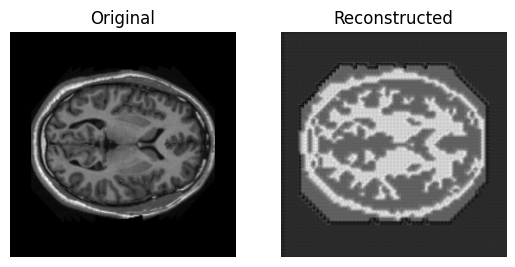

In [2]:

test_images = val_ds.take(1)
reconstructed_test_images = vqvae.predict(test_images)
reconstructed_test_images.shape

#plt.imshow(reconstructed_test_images[0],cmap=None)

for test_image, reconstructed_image in zip(test_images, reconstructed_test_images):
    show_original_vs_reconstructed(test_image[0], reconstructed_image)

In [ ]:
encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

In [ ]:
encoded_outputs = encoder.predict(train_ds / 255.0)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

In [ ]:
for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [ ]:
# PixelCNN hyperparameters
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]

